<a href="https://colab.research.google.com/github/tejash2005/first_github_repo/blob/main/Product_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **All top products**

In [40]:
# ✅ 1. Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

# ✅ 2. Load Data
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/cleaned_retail_data.csv")

# ✅ 3. Clean Data
df.dropna(subset=['CustomerID', 'Description'], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['Description'] = df['Description'].str.lower()

# ✅ 4. Popularity Model
from sklearn.preprocessing import MinMaxScaler

popularity = df.groupby('Description').agg({
    'Quantity': 'sum',
    'InvoiceNo': 'nunique',
    'UnitPrice': 'mean'
}).reset_index()

scaler = MinMaxScaler()
popularity['popularity_score'] = (
    0.7 * scaler.fit_transform(popularity[['Quantity']]) +
    0.3 * scaler.fit_transform(popularity[['InvoiceNo']])
)

# Keep top 500 for speed & diversity
top_popular_items = popularity.sort_values(by='popularity_score', ascending=False).head(500)

# ✅ 5. Content-Based Model (TF-IDF on product description)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Use only unique products
unique_products = df[['Description']].drop_duplicates()
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(unique_products['Description'])

# Compute cosine similarity between all products
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Index map
indices = pd.Series(unique_products.index, index=unique_products['Description'])

# ✅ 6. Hybrid Recommendation Function

def hybrid_recommendation(n=10):
    hybrid_result = []

    # Ensure we use only descriptions that exist in the TF-IDF matrix
    valid_popular_descriptions = [desc for desc in top_popular_items['Description'].tolist()
                                  if desc in indices]

    for item in valid_popular_descriptions[:20]:  # use only top 20 for diversity
        idx = indices.get(item)
        if idx is None or idx >= cosine_sim.shape[0]:  # safety check
            continue

        # Get similarity scores for the product
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get top 3 similar product indices (excluding itself)
        sim_indices = [i[0] for i in sim_scores[1:4]]

        # Add original + similar products
        hybrid_result.append(item)
        hybrid_result += unique_products.iloc[sim_indices]['Description'].tolist()

        if len(hybrid_result) >= n:
            break

    # Remove duplicates and truncate to n results
    seen = set()
    final_list = []
    for item in hybrid_result:
        if item not in seen:
            seen.add(item)
            final_list.append(item)
        if len(final_list) == n:
            break

    return final_list



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
recommendations = hybrid_recommendation(100)
print(" Hybrid Recommendations for New Customer:")
for i, item in enumerate(recommendations, 1):
    print(f"{i}. {item}")


 Hybrid Recommendations for New Customer:
1. jumbo bag red retrospot
2. love hot water bottle
3. grey heart hot water bottle
4. chocolate hot water bottle
5. white hanging heart t-light holder
6. pink hanging heart t-light holder
7. red hanging heart t-light holder
8. hanging heart zinc t-light holder
9. world war 2 gliders asstd designs
10. scottie dogs baby bib
11. wrap, carousel
12. wrap carousel
13. assorted colour bird ornament
14. assorted colour t-light holder
15. assorted colour metal cat 
16. assorted colour mini cases
17. pack of 72 retrospot cake cases
18. flowers tile hook
19. flowers  stickers
20. heart of wicker small
21. regency cakestand 3 tier
22. wicker wreath small
23. wicker wreath large
24. easter bunny wreath
25. lunch bag red retrospot
26. pink breakfast cup and saucer 
27. blue breakfast cup and saucer 
28. red retrospot tea cup and saucer 
29. victorian glass hanging t-light
30. kings choice mug
31. glass jar kings choice
32. paperweight kings choice 
33. pack 

# Top products related to the keyword

In [33]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# Load your data
# ✅ 1. Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

# ✅ 2. Load Data
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/cleaned_retail_data.csv")  # Change to your actual product file
df.dropna(subset=['Description'], inplace=True)


# Optional: drop exact duplicate descriptions (if that's causing repetition)
df = df.drop_duplicates(subset='Description').reset_index(drop=True)

# TF-IDF on description
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Description'])

# Normalize Popularity
if 'Popularity' not in df.columns:
    df['Popularity'] = 1

scaler = MinMaxScaler()
df['NormPopularity'] = scaler.fit_transform(df[['Popularity']])

# Function: hybrid recommend using keyword
def get_hybrid_scores_for_keyword(keyword, top_n=10):
    keyword = keyword.lower().strip()

    # Create a vector for the input keyword using same TF-IDF vectorizer
    keyword_vec = tfidf.transform([keyword])
    similarities = cosine_similarity(keyword_vec, tfidf_matrix).flatten()

    # Combine with popularity
    scores_df = pd.DataFrame({
        'Description': df['Description'],
        'ContentScore': similarities,
        'NormPopularity': df['NormPopularity']
    })
    scores_df['HybridScore'] = 0.7 * scores_df['ContentScore'] + 0.3 * scores_df['NormPopularity']

    # Filter out only meaningful matches (e.g. similarity > 0.1)
    filtered = scores_df[scores_df['ContentScore'] > 0.1]
    if filtered.empty:
        return f"No relevant products found for '{keyword}'"

    # Return all relevant products sorted by hybrid score
    return filtered.sort_values('HybridScore', ascending=False).reset_index(drop=True)

# Example usage
product_keyword = input("Enter a product keyword: ")
recommendations = get_hybrid_scores_for_keyword(product_keyword)

print("\n🔍 Top Related Products:\n")
print(recommendations[['Description', 'ContentScore', 'NormPopularity', 'HybridScore']])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter a product keyword: bottle

🔍 Top Related Products:

                            Description  ContentScore  NormPopularity  \
0                 BOTTLE BAG RETROSPOT       0.661393             0.0   
1         ASSORTED BOTTLE TOP  MAGNETS       0.568551             0.0   
2             HANGING CLEAR MINI BOTTLE      0.492120             0.0   
3                 LOVE HOT WATER BOTTLE      0.491933             0.0   
4            CHOCOLATE HOT WATER BOTTLE      0.477982             0.0   
5      RETROSPOT HEART HOT WATER BOTTLE      0.474464             0.0   
6       DECORATIVE ROSE BATHROOM BOTTLE      0.474331             0.0   
7            HOT WATER BOTTLE BABUSHKA       0.473285             0.0   
8            HOT WATER BOTTLE KEEP CALM      0.454620             0.0   
9              LAVENDER TOILETTE BOTTLE      0.454414             0.0   
10        

In [34]:
from sklearn.metrics import precision_score, recall_score

def evaluate_precision_recall_at_k(k=10, threshold=0.1, sample_size=1000):
    """
    Automatically compute average Precision@k and Recall@k for a random sample of products.
    """
    all_precisions = []
    all_recalls = []

    sample_df = df.sample(n=sample_size, random_state=42)

    for _, row in sample_df.iterrows():
        keyword = row['Description']
        true_vector = tfidf.transform([keyword])
        similarities = cosine_similarity(true_vector, tfidf_matrix).flatten()

        # Build relevance ground truth
        relevant_indices = np.where(similarities > threshold)[0]
        relevant_indices = relevant_indices[relevant_indices != row.name]  # Exclude itself

        # Predicted top-k from hybrid function
        recs = get_hybrid_scores_for_keyword(keyword, top_n=k)
        if isinstance(recs, str):  # No relevant products
            continue

        predicted_indices = df[df['Description'].isin(recs['Description'].head(k))].index.values

        # True positives = intersection
        true_positives = len(set(predicted_indices) & set(relevant_indices))

        precision = true_positives / k
        recall = true_positives / len(relevant_indices) if len(relevant_indices) > 0 else 0

        all_precisions.append(precision)
        all_recalls.append(recall)

    avg_precision = np.mean(all_precisions)
    avg_recall = np.mean(all_recalls)

    print(f"\n📊 Precision@{k}: {avg_precision:.4f}")
    print(f"📊 Recall@{k}: {avg_recall:.4f}")

# Run evaluation
evaluate_precision_recall_at_k(k=10, sample_size=1000)  # You can increase sample_size if your data is big



📊 Precision@10: 0.8950
📊 Recall@10: 0.1224


In [35]:
# Example format after recommendation
recommended_df = pd.DataFrame({
    'Description': [
    "BOTTLE BAG RETROSPOT",
    "ASSORTED BOTTLE TOP  MAGNETS",
    "HANGING CLEAR MINI BOTTLE",
    "LOVE HOT WATER BOTTLE",
    "CHOCOLATE HOT WATER BOTTLE",
    "RETROSPOT HEART HOT WATER BOTTLE",
    "DECORATIVE ROSE BATHROOM BOTTLE",
    "HOT WATER BOTTLE BABUSHKA",
    "HOT WATER BOTTLE KEEP CALM",
    "LAVENDER TOILETTE BOTTLE",
    "WHITE SKULL HOT WATER BOTTLE",
    "GLASS APOTHECARY BOTTLE TONIC",
    "HOT WATER BOTTLE BABUSHKA LARGE",
    "ENGLISH ROSE HOT WATER BOTTLE",
    "MILK BOTTLE WITH GLASS STOPPER",
    "GREY HEART HOT WATER BOTTLE",
    "DECORATIVE CATS BATHROOM BOTTLE",
    "UNION JACK HOT WATER BOTTLE",
    "HOT WATER BOTTLE I AM SO POORLY",
    "BIRD HOUSE HOT WATER BOTTLE",
    "GLASS APOTHECARY BOTTLE PERFUME",
    "GLASS APOTHECARY BOTTLE ELIXIR",
    "FAWN BLUE HOT WATER BOTTLE",
    "BULL DOG BOTTLE TOP WALL CLOCK",
    "RED WHITE SCARF  HOT WATER BOTTLE",
    "DECORATIVE FLORE BATHROOM BOTTLE",
    "CHARLIE+LOLA PINK HOT WATER BOTTLE",
    "CHICK GREY HOT WATER BOTTLE",
    "CHARLIE LOLA BLUE HOT WATER BOTTLE",
    "SCOTTIE DOG HOT WATER BOTTLE",
    "CHARLIE + LOLA RED HOT WATER BOTTLE",
    "CHARLIE+LOLA RED HOT WATER BOTTLE",
    "PINK HEART DOTS HOT WATER BOTTLE",
    "HOT WATER BOTTLE TEA AND SYMPATHY",
    "BULL DOG BOTTLE OPENER",
    "HOME SWEET HOME BOTTLE",
    "WINE BOTTLE DRESSING DARK BLUE",
    "WINE BOTTLE DRESSING LT.BLUE",
    "KNITTED UNION FLAG HOT WATER BOTTLE",
    "HOT WATER BOTTLE SEX BOMB",
    "HOT STUFF HOT WATER BOTTLE"
]
,
    'HybridScore': [  0.661393,
    0.568551,
    0.492120,
    0.491933,
    0.477982,
    0.474464,
    0.474331,
    0.473285,
    0.454620,
    0.454414,
    0.441945,
    0.440661,
    0.439971,
    0.433705,
    0.429913,
    0.427339,
    0.426878,
    0.421158,
    0.420439,
    0.420188,
    0.417864,
    0.417864,
    0.411127,
    0.405281,
    0.404249,
    0.403580,
    0.398558,
    0.396545,
    0.396188,
    0.395810,
    0.395231,
    0.395231,
    0.391221,
    0.390743,
    0.383432,
    0.383336,
    0.370128,
    0.366354,
    0.363478,
    0.357132,
    0.337605]
})


/tmp/ipython-input-36-4199579271.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-36-4199579271.py:25: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


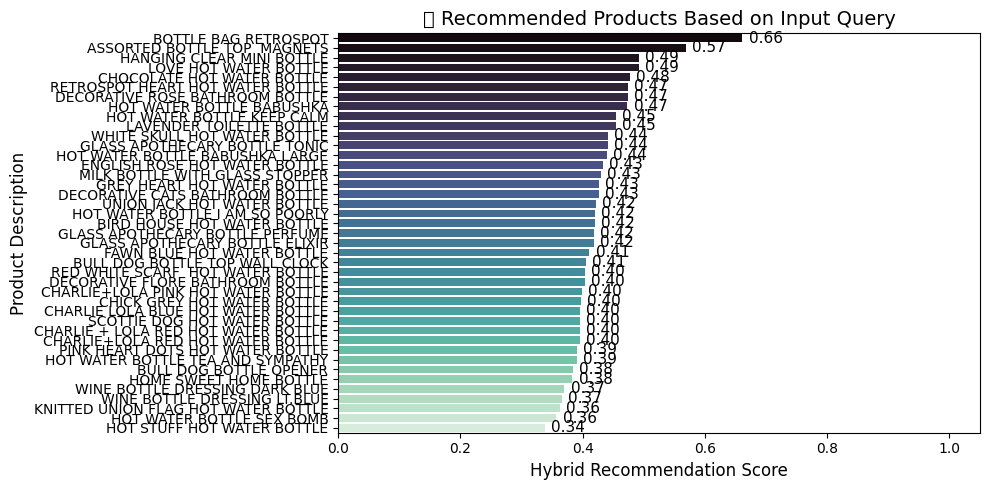

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by score for better visualization
recommended_df = recommended_df.sort_values(by='HybridScore', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(
    data=recommended_df,
    x='HybridScore',
    y='Description',
    palette='mako'
)

plt.title("🔍 Recommended Products Based on Input Query", fontsize=14)
plt.xlabel("Hybrid Recommendation Score", fontsize=12)
plt.ylabel("Product Description", fontsize=12)
plt.xlim(0, 1.05)

# Annotate score on bars
for index, row in recommended_df.iterrows():
    plt.text(row.HybridScore + 0.01, index, f"{row.HybridScore:.2f}", va='center', fontsize=11)

plt.tight_layout()
plt.show()
